In [496]:
from scipy.io import wavfile
import numpy.fft as fft
import numpy as np
from scipy import signal

In [497]:
Fs, data = wavfile.read("../../materijali-sa-vezbi/04_05_06_mr.furije/04/data/bonobo.wav")

In [498]:
data1 = data[:,0]
data2 = data[:,1]

In [499]:
window = signal.windows.kaiser(len(data1) // 2 + 1, 5)

In [500]:
c1 = fft.rfft(data1, norm='ortho') * window
c2 = fft.rfft(data2, norm='ortho') * window

In [501]:
freq = fft.fftfreq(len(data1)//2+1, 1 / Fs)

In [502]:
mask = (freq > -15000) * (freq < 15000)
c1_filtered = c1[mask]
c2_filtered = c2[mask]
freq_filtered = freq[mask]

In [503]:
data1_new = fft.irfft(c1_filtered)
data2_new = fft.irfft(c2_filtered)

In [504]:
c1_filtered.shape

(450001,)

In [505]:
final_data = np.array([data1_new, data2_new]).T

In [506]:
final_data.shape

(900000, 2)

In [507]:
wavfile.write("test.wav", Fs, final_data)

In [510]:
import matplotlib.pyplot as plt

/home/denis/miniconda3/envs/audio/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


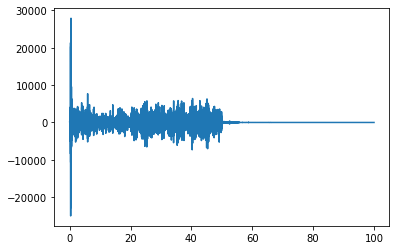

In [512]:
plt.plot(np.linspace(0,100,c1_filtered.shape[0]), c1_filtered)